In [1]:
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow.keras.backend as K
from tensorflow.keras import activations
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Lambda,Activation,Input,Flatten,Conv2DTranspose,concatenate,Reshape,LeakyReLU

# Set some options and read file names and attribute data

In [18]:
#options
IMG_DIM = 64
DIM_S = 2
supervised = True #False:Unsupervised
prior_dist = 0 # 0: Isotropic 1: guassian mixture
sensitive = 'emotion' #'gender' or 'emotion'



# automatically set variables based on selected options
DIM_U = 2 if supervised else [IMG_DIM, IMG_DIM, 64]
utility = 'emotion' if sensitive == 'gender' else 'gender'
prior_type = 'Isotropic' if prior_dist == 0 else 'Mixture'
exp_info = f"s_{sensitive}_u_{utility}_{prior_type}_supervised" if supervised else f"s_{sensitive}_{prior_type}_unsupervised"
exp_info += "_P5"

#Folder and image files
generalFolder = './CelebA/'
folder = generalFolder + 'img_align_celeba/'
allFiles = [folder + "/" + f for f in sorted(os.listdir(folder))]#Folder and image files
n = len(allFiles)
print("Number of data : ", n)

df = pd.read_csv(generalFolder + 'list_attr_celeba.csv', nrows=n)
df.head()

Number of data :  202599


,file_name,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


# Loading U and S

In [19]:
S = df['Male'].to_numpy() if(sensitive == 'gender') else df['Smiling'].to_numpy()
S[S == -1] = 0

if supervised:
    U = df['Smiling'].to_numpy() if(sensitive == 'gender') else df['Male'].to_numpy()
    U[U == -1] = 0

# Reading partion information for split data into test, train and validation sets

In [4]:
eval_part = pd.read_csv(generalFolder + 'list_eval_partition.txt', header=None, sep=" ").to_numpy()[:, 1].astype(int)
print(eval_part.shape)
n_train = sum(eval_part == 0)
n_valid = sum(eval_part == 1)
n_test  = sum(eval_part == 2)
print(n_train, n_valid, n_test)

(202599,)
162770 19867 19962


# Reading image data

# one hot U and S in order to ready them for the model

In [ ]:
x_train = np.zeros((n_train, IMG_DIM, IMG_DIM, 3))
x_valid = np.zeros((n_valid, IMG_DIM, IMG_DIM, 3))
x_test = np.zeros((n_test, IMG_DIM, IMG_DIM, 3))

print("Reading train data:")
for i in range(0,n_train):
  if (i+1) % 20000 == 0:
    print(f"{i+1} / {n_train}")
  img = cv2.imread(allFiles[i])
  img = cv2.resize(img,(IMG_DIM,IMG_DIM),interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  x_train[i, :, :, :] = img / 255.0

print("Reading validation data:")
for i in range(n_train,(n_train+n_valid)):
  if (i-n_train+1) % 5000 == 0:
    print(f"{i-n_train+1} / {n_valid}")
  img = cv2.imread(allFiles[i])
  img = cv2.resize(img,(IMG_DIM,IMG_DIM),interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  x_valid[i-n_train, :, :, :] = img / 255.0
    
print("Reading test data:")
for i in range((n_train+n_valid),202599):
  if (i-(n_train+n_valid)+1) % 5000 == 0:
    print(f"{i-(n_train+n_valid)+1} / {n_test}")
  img = cv2.imread(allFiles[i])
  img = cv2.resize(img,(IMG_DIM,IMG_DIM),interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  x_test[i-(n_train+n_valid), :, :, :] = img / 255.0

In [ ]:
def one_hot(labels, num_labels):
    num_labels_data = labels.shape[0]
    one_hot_encoding = np.zeros((num_labels_data,num_labels))
    one_hot_encoding[np.arange(num_labels_data),labels] = 1
    one_hot_encoding = np.reshape(one_hot_encoding, [-1, num_labels])
    return one_hot_encoding

s_train = one_hot(S[:n_train], DIM_S).astype(np.float32)
s_valid = one_hot(S[n_train:(n_train+n_valid)], DIM_S).astype(np.float32)
s_test = one_hot(S[(n_train+n_valid):], DIM_S).astype(np.float32)

if not supervised:
    u_train = x_train
    u_valid = x_valid
    u_test = x_test
else:
    u_train = one_hot(U[:n_train], DIM_U).astype(np.float32)
    u_valid = one_hot(U[n_train:(n_train+n_valid)], DIM_U).astype(np.float32)
    u_test = one_hot(U[(n_train+n_valid):], DIM_U).astype(np.float32)

print(s_train.shape, s_valid.shape, s_test.shape)    
print(u_train.shape, u_valid.shape, u_test.shape)

# Define model

In [ ]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
def get_encoder(DIM_Z, input_x):
    stride = 2
#     input_x = Input( shape = [IMG_DIM,IMG_DIM,3], name="x" )

    #first hidden layer
    x = Conv2D(16, 3, strides=stride, padding="same", name="enc_h1")(input_x)
    x = BatchNormalization(name="enc_h1_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h1_activation")(x)
    #second hidden layer
    x = Conv2D(32, 3, strides=stride, padding="same", name="enc_h2")(x)
    x = BatchNormalization(name="enc_h2_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h2_activation")(x)
    #third hidden layer
    x = Conv2D(64, 3, strides=stride, padding="same", name="enc_h3")(x)
    x = BatchNormalization(name="enc_h3_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h3_activation")(x)
    #forth hidden layer
    x = Conv2D(128, 3, strides=stride, padding="same", name="enc_h4")(x)
    x = BatchNormalization(name="enc_h4_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h4_activation")(x)
    #fifth hidden layer
    x = Conv2D(256, 3, strides=stride, padding="same", name="enc_h5")(x)
    x = BatchNormalization(name="enc_h5_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h5_activation")(x)
    
    shape = K.int_shape(x)
    x = Flatten()(x)
    x = Dense(DIM_Z*4, name="enc_dense_1")(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    z_mean = Dense(DIM_Z, name="z_mean")(x)
    z_log_sigma_sq = Dense(DIM_Z, name="z_sigma")(x)
    z = Lambda(sampling, output_shape=DIM_Z, name='lambda_z')([z_mean, z_log_sigma_sq])
    
#     prior_loss = K.mean(-0.5 * K.sum(1 + z_log_sigma_sq - K.square(z_mean) - K.exp(z_log_sigma_sq), axis=-1))
    
    encoder = Model(input_x, z, name = "Encoder")
#     encoder.add_loss((alpha+beta) * prior_loss)
    
    return (encoder, z_mean, z_log_sigma_sq)

In [ ]:
def get_uncertainty_model(DIM_Z):
    model = Sequential(name="Uncertainty_Decoder")
    model.add(Dense(DIM_Z * 4, input_dim=DIM_Z))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(DIM_S, activation='softmax', name="s_hat"))
    return model

In [ ]:
if supervised:
    def get_utility_model(DIM_Z):
        model = Sequential(name="Utility_Decoder_supervised")
        model.add(Dense(DIM_Z, input_dim=DIM_Z))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(DIM_U, activation='softmax', name="u_hat"))
        return model
else:
    def get_utility_model(DIM_Z):
        stride = 2
        model = Sequential(name="Utility_Decoder_unsupervised")
        model.add(Dense(2*2*256, input_dim=DIM_Z))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Reshape((2,2,256)))
        
        model.add(Conv2DTranspose(128, 3, strides=stride, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(64, 3, strides=stride, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(32, 3, strides=stride, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(16, 3, strides=stride, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(8, 3, strides=stride, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2D(3, 3, strides=1, padding="same", activation='sigmoid', name="u_hat"))
        return model

In [ ]:
def get_z_discriminator(DIM_Z):
    model = Sequential(name="Latent_Space_Discriminator")
    
    model.add(Dense(512, input_dim=DIM_Z))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

In [ ]:
def get_utility_discriminator():
    model = Sequential(name="Attribute_Class_Discriminator")

    model.add(Dense(DIM_U * 8, input_dim=DIM_U))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(DIM_U * 8))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

In [ ]:
def get_visible_space_discriminator():
    stride = 2
    model = Sequential(name="Visible_Space_Discriminator")
    
    model.add(Input(shape = [IMG_DIM,IMG_DIM,3]))
    
    model.add(Conv2D(16, 3, strides=stride, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(32, 3, strides=stride, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(64, 3, strides=stride, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, 3, strides=stride, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

In [ ]:
def get_uncertainty_discriminator():
    model = Sequential(name="Uncertainty_Discriminator")

    model.add(Dense(DIM_S * 8, input_dim=DIM_S))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(DIM_S * 8))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

In [ ]:
def get_prior_generator(DIM_Z, noise_dim=100):
    model = Sequential(name="Prior_Distribution_Generator")
    
    model.add(Dense(noise_dim*2, input_dim=noise_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(noise_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(DIM_Z))
    
    return model

Optional: Train a model to evaluate output of the main model

In [ ]:
def get_eval_model():
    stride = 2
    #declare inputs to the encoder, which is just x
    input_x = Input( shape = [IMG_DIM,IMG_DIM,3], name="x" )

    #first hidden layer
    x = Conv2D(32, 3, strides=stride, padding="same", name="h1")(input_x)
    x = BatchNormalization(name="h1_normalized")(x)
    x = Activation(LeakyReLU(), name="h1_activation")(x)

    #second hidden layer
    x = Conv2D(64, 3, strides=stride, padding="same", name="h2")(x)
    x = BatchNormalization(name="h2_normalized")(x)
    x = Activation(LeakyReLU(), name="h2_activation")(x)

    #third hidden layer
    x = Conv2D(128, 3, strides=stride, padding="same", name="h3")(x)
    x = BatchNormalization(name="h3_normalized")(x)
    x = Activation(LeakyReLU(), name="h3_activation")(x)

    #forth hidden layer
    x = Conv2D(256, 3, strides=stride, padding="same", name="h4")(x)
    x = BatchNormalization(name="h4_normalized")(x)
    x = Activation(LeakyReLU(), name="h4_activation")(x)

    x = Flatten()(x)

    x = Dense(1024, activation="relu", name="dense1")(x)
    x = BatchNormalization(name="dense1_normalized")(x)

    s_hat = Dense(DIM_S, activation="softmax", name='s_hat')(x)
    
    return Model(input_x, s_hat, name="CNN_Model_test_sensitivity")

In [ ]:
if not supervised:
    eval_model = get_eval_model()
    eval_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='binary_crossentropy')

    force_train = False

    if not os.path.exists(f"saved_models/celeba_eval_model_{exp_info}.h5") or force_train:
        print("Training sensitive attribute evaluator")
        history = eval_model.fit(x_train, s_train, validation_data=(x_valid, s_valid), batch_size=1024, epochs=50, shuffle=True, verbose=2)
        eval_model.save_weights(f"saved_models/celeba_eval_model_{exp_info}.h5")
    else:
        print("Loading sensitive attribute evaluator from file")
        eval_model.load_weights(f"saved_models/celeba_eval_model_{exp_info}.h5")

    ## Evaluating evaluator!
    s_hat_test = eval_model.predict(x_test)
    print(sum(np.argmax(s_hat_test,axis=-1)==np.argmax(s_test,axis=-1)) / s_test.shape[0])

# Putting all togther - define CLUB model

In [ ]:
z_gen_enabled = False #if False, the algorithm sample prior from Normal Distribution
## utility and reconstruction losses
if supervised:
    def loss_u(gamma):
        def loss(u_true, u_pred):
            return gamma * K.mean(K.sum(K.square(u_true-u_pred), axis=-1))
        return loss
else:
    def loss_u(gamma):
        def loss(u_true, u_pred):
            return gamma * K.mean(K.sum(K.square(u_true-u_pred), axis=(1,2,3)))
        return loss

def loss_s(lam):
    def loss(s_true, s_pred):
        return lam * -K.mean(K.sum(K.square(s_true-s_pred), axis=-1))
    return loss

bce = tf.keras.losses.BinaryCrossentropy()
# Weighted cross-entropy loss
def loss_wce(coef):
    def loss(y, y_pred):
         return coef * bce(y, y_pred)
    return loss

def get_full_model(DIM_Z, lam, gamma, learning_rate=0.0001, dim_noise = 100):
    ########## Inputs
    input_x = Input( shape=[IMG_DIM,IMG_DIM,3], name="x" )
    input_z = Input( shape = (DIM_Z,), name="z" )
    input_noise = Input( shape = (dim_noise,), name="Noise")

    ########## Define AE: Encoder, Utility Decoder and Uncertainty Decoder
    encoder,z_mean,z_log_sigma_sq = get_encoder(DIM_Z, input_x)
    uncertainty_decoder = get_uncertainty_model(DIM_Z)
    utility_decoder = get_utility_model(DIM_Z)

    z = encoder(input_x)
    s_hat = uncertainty_decoder(z)
    u_hat = utility_decoder(z)

    autoencoder = Model(input_x, [s_hat, u_hat], name="CLUB_Autoencoder")
    prior_loss = K.mean(-0.5 * K.sum(1 + z_log_sigma_sq - K.square(z_mean) - K.exp(z_log_sigma_sq), axis=-1))
    prior_loss = tf.identity(prior_loss, name="kl_loss")
    autoencoder.add_loss(prior_loss)
    autoencoder.compile(loss=[loss_s(lam), loss_u(gamma)], optimizer=tf.keras.optimizers.Adam(lr=learning_rate*5))

    ########## Define Latent Space Discriminator
    z_discriminator = get_z_discriminator(DIM_Z)
    z_discriminator.compile(loss=loss_wce(0.1), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ##########
    #z_discriminator should train separately
    z_discriminator.trainable = False
    prior_generator = get_prior_generator(DIM_Z, dim_noise)
    prior_gen_zdiscriminator = Model(input_noise, z_discriminator(prior_generator(input_noise)), name="CLUB_generator_zdiscriminator")
    prior_gen_zdiscriminator.compile(loss=loss_wce(-0.1), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ##########
    encoder_zdiscriminator = Model(input_x, z_discriminator(encoder(input_x)), name="CLUB_encoder_zdiscriminator")
    encoder_zdiscriminator.compile(loss=loss_wce(-0.1), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ##########
    u_dircriminator = get_utility_discriminator() if supervised else get_visible_space_discriminator()
    u_dircriminator.compile(loss=loss_wce(0.1*gamma), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ##########
    #u_dircriminator should train separately
    u_dircriminator.trainable = False

    if z_gen_enabled:    
        decoder_udiscriminator = Model(input_noise, u_dircriminator(utility_decoder(prior_generator(input_noise))), name="CLUB_decoder_udiscriminator")
    else:
        decoder_udiscriminator = Model(input_z, u_dircriminator(utility_decoder(input_z)), name="CLUB_decoder_udiscriminator")

    decoder_udiscriminator.compile(loss=loss_wce(-0.1*gamma), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ##########
    s_dircriminator = get_uncertainty_discriminator()
    s_dircriminator.compile(loss=loss_wce(-0.1*lam), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ##########
    #s_dircriminator should train separately
    s_dircriminator.trainable = False
    if z_gen_enabled:
        decoder_sdiscriminator = Model(input_noise, s_dircriminator(uncertainty_decoder(prior_generator(input_noise))), name="CLUB_decoder_sdiscriminator")
    else:
        decoder_sdiscriminator = Model(input_z, s_dircriminator(uncertainty_decoder(input_z)), name="CLUB_decoder_sdiscriminator")

    decoder_sdiscriminator.compile(loss=loss_wce(0.1 * lam), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))
                                   
    return encoder, uncertainty_decoder, utility_decoder, autoencoder, z_discriminator, prior_generator, prior_gen_zdiscriminator, encoder_zdiscriminator, u_dircriminator, decoder_udiscriminator, s_dircriminator, decoder_sdiscriminator

In [ ]:
# for test
# encoder, uncertainty_decoder, utility_decoder, autoencoder, z_discriminator, prior_generator, prior_gen_zdiscriminator, encoder_zdiscriminator, u_dircriminator, decoder_udiscriminator, s_dircriminator, decoder_sdiscriminator= get_full_model(32,0.1,0.1)
# tf.keras.utils.plot_model(decoder_udiscriminator, show_shapes=True)
# tf.keras.utils.plot_model(autoencoder,show_shapes=True)

# Pre-training implementation

In [ ]:
def pre_train_ae(dim_z, lam, gamma, force_train=False, max_itr=100, batch_size=1024, verbose=2):
    info_str = f"d_{dim_z}_lambda_{lam}_gamma_{gamma}_{exp_info}"
    if not os.path.exists(f"saved_models/celeba_pretrain_{info_str}.h5") or force_train:
        print(f"Pre-Training with {info_str}")
        autoencoder.fit(x_train, [s_train, u_train], validation_data=(x_valid, [s_valid, u_valid]), batch_size=batch_size, epochs=max_itr, shuffle=True, verbose=verbose)
        autoencoder.save_weights(f"saved_models/celeba_pretrain_{info_str}.h5")
    else:
        print(f"Loading model from file with {info_str}")
        autoencoder.load_weights(f"saved_models/celeba_pretrain_{info_str}.h5")

In [ ]:
from utils.sampler import gaussian, gaussian_mixture

def sample_prior(latent_dim, batch_size):
    if prior_dist == 0:  
        return gaussian(batch_size, latent_dim)
    elif prior_dist == 1:
        return gaussian_mixture(batch_size, latent_dim, num_labels=min(10, DIM_U))

In [ ]:
def main_train(dim_z, max_itr=2000, batch_size=1024, z_disc_enabled=True,u_disc_enabled=True,s_disc_enabled=True,verbose=1,dim_noise=100):
    ones = np.ones((batch_size, 1))
    zeros = np.zeros((batch_size, 1))
    start_time = time.time()
    for epoch in range(max_itr):
        start_time_epoch = time.time()
        # Select a random batch of images
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        x = x_train[idx]
        s = s_train[idx]
        u = u_train[idx]
        # ---------------------
        #  1- Train the Encoder, Utility Decoder, Uncertainty Decoder
        # ---------------------
        ae_loss = autoencoder.train_on_batch(x, [s, u])

        if z_disc_enabled:
        # ---------------------
        #  2- Train the Latent Space Discriminator
        # ---------------------

            if z_gen_enabled:
                noise = np.random.uniform(-1.0, 1.0, size=[batch_size, dim_noise])
                latent_prior = prior_generator(noise)
            else:
                latent_prior = sample_prior(dim_z, batch_size)

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            x = x_train[idx]
            latent_enc = encoder(x)

            d_loss_prior = z_discriminator.train_on_batch(latent_prior, zeros)
            d_loss_enc = z_discriminator.train_on_batch(latent_enc, ones)
            dz_loss = d_loss_prior + d_loss_enc

            # ---------------------
            # 3- Train the Encoder and Prior Distribution Generator Adversarially
            # ---------------------
            prior_loss = 0.
            if z_gen_enabled:
                noise = np.random.uniform(-1.0, 1.0, size=[batch_size, dim_noise])
                prior_loss = prior_gen_zdiscriminator.train_on_batch(noise, zeros)

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            x = x_train[idx]
            edz_loss = encoder_zdiscriminator.train_on_batch(x, ones)
        else:
            dz_loss = 0.
            prior_loss = 0.
            edz_loss = 0.

        if u_disc_enabled:
        # ---------------------
        #  4- Train Visible_Space/Attribute_Class Discriminator 
        # ---------------------

            if z_gen_enabled:
                noise = np.random.uniform(-1.0, 1.0, size=[batch_size, dim_noise])
                latent = prior_generator(noise)
            else:
                latent = sample_prior(dim_z, batch_size)
            u_dec = utility_decoder(latent)

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            u = u_train[idx]

            d_loss_real = u_dircriminator.train_on_batch(u, ones)
            d_loss_fake = u_dircriminator.train_on_batch(u_dec, zeros)
            du_loss = d_loss_real + d_loss_fake

        # ---------------------
        #  5- Train the Prior Distribution Generator and Utility Decoder Adversarially
        # ---------------------
            if z_gen_enabled:
                noise = np.random.uniform(-1.0, 1.0, size=[batch_size, dim_noise])
                gdu_loss = decoder_udiscriminator.train_on_batch(noise, zeros)
            else:    
                latent = sample_prior(dim_z, batch_size)
                gdu_loss = decoder_udiscriminator.train_on_batch(latent, zeros)
        else:
            gdu_loss = 0.
            du_loss = 0.

        # ---------------------
        #  6- Train the Uncertainty Discriminator
        # ---------------------
        if s_disc_enabled:
            
            if z_gen_enabled:
                noise = np.random.uniform(-1.0, 1.0, size=[batch_size, dim_noise])
                latent = prior_generator(noise)
            else:
                latent = sample_prior(dim_z, batch_size)
            s_dec = uncertainty_decoder(latent)

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            s = s_train[idx]

            d_loss_1 = s_dircriminator.train_on_batch(s, ones)
            d_loss_2 = s_dircriminator.train_on_batch(s_dec, zeros)
            ds_loss = d_loss_1 + d_loss_2
        # ---------------------
        #  7- Train the Prior Distribution Generator and Uncertainty Decoder Adversarially
        # ---------------------
            if z_gen_enabled:
                noise = np.random.uniform(-1.0, 1.0, size=[batch_size, dim_noise])
                gds_loss = decoder_sdiscriminator.train_on_batch(noise, zeros)
            else:    
                latent = sample_prior(dim_z, batch_size)
                gds_loss = decoder_sdiscriminator.train_on_batch(latent, zeros)
        else:
            ds_loss = 0.
            gds_loss = 0.
        
        # ---------------------
        #  Print stats info
        # ---------------------
        if verbose != 0 and epoch % 20 == 0:
            print(f"{epoch}, s:{ae_loss[1]:.4f}, u:{ae_loss[2]:.4f}, dz:{dz_loss:.4f}, edz:{edz_loss:.4f}, prior:{prior_loss:.4f}, du:{du_loss:.4f}, gdu:{gdu_loss:.4f}, ds:{ds_loss:.4f}, gds:{gds_loss:.4f}")
            print(f"One epoch execution time: {(time.time() - start_time_epoch):.5} seconds")

    total_time = (time.time() - start_time) / 60
    print(f"Total Execution Time: {total_time:.4f} minutes")

# Experiment 1

In [ ]:
from utils.mine import MINE
lam_list = [0.0001, 0.1, 10, 1000]
gamma_list = [0.0001, 0.1, 10, 1000]
DIM_Z = [64, 128]

util_acc_tr = np.zeros((len(DIM_Z),len(lam_list),len(gamma_list)))
util_acc_ts = np.zeros((len(DIM_Z),len(lam_list),len(gamma_list)))
util_acc_va = np.zeros((len(DIM_Z),len(lam_list),len(gamma_list)))
sens_acc_tr = np.zeros((len(DIM_Z),len(lam_list),len(gamma_list)))
sens_acc_ts = np.zeros((len(DIM_Z),len(lam_list),len(gamma_list)))

mi_u_ts = np.zeros((len(DIM_Z),len(lam_list),len(gamma_list)))
mi_u_tr = np.zeros((len(DIM_Z),len(lam_list),len(gamma_list)))
mi_s_ts = np.zeros((len(DIM_Z),len(lam_list),len(gamma_list)))
mi_s_tr = np.zeros((len(DIM_Z),len(lam_list),len(gamma_list)))


for i, dimz in enumerate(DIM_Z):
    for j, lam in enumerate(lam_list):
        for k, gamma in enumerate(gamma_list):
            #Pre training
            encoder, uncertainty_decoder, utility_decoder, autoencoder, z_discriminator, prior_generator, prior_gen_zdiscriminator, encoder_zdiscriminator, u_dircriminator, decoder_udiscriminator, s_dircriminator, decoder_sdiscriminator = get_full_model(dimz, lam, gamma)
            pre_train_ae(dimz, lam, gamma, force_train=False, max_itr=100, batch_size=1024, verbose=2)
            
            print("Full model training")
            main_train(dimz, max_itr=50, batch_size=2048)

            print("Evaluate performance of U")
            z_test = encoder.predict(x_test)
            z_train = encoder.predict(x_train)
            z_valid = encoder.predict(x_valid)
            
            u_test_hat = utility_decoder.predict(z_test)
            u_train_hat = utility_decoder.predict(z_train)
            u_valid_hat = utility_decoder.predict(z_valid)
            if supervised:
                util_acc_ts[i][j][k] = np.mean(np.argmax(u_test_hat,axis=1)==np.argmax(u_test,axis=1)) * 100
                util_acc_tr[i][j][k] = np.mean(np.argmax(u_train_hat,axis=1)==np.argmax(u_train,axis=1)) * 100
                util_acc_va[i][j][k] = np.mean(np.argmax(u_valid_hat,axis=1)==np.argmax(u_valid,axis=1)) * 100
            else:
                util_acc_ts[i][j][k] = np.mean(np.sum(np.square(u_test_hat-u_test), axis=(1,2,3)))
                util_acc_tr[i][j][k] = np.mean(np.sum(np.square(u_train_hat-u_train), axis=(1,2,3)))
                util_acc_va[i][j][k] = np.mean(np.sum(np.square(u_valid_hat-u_valid), axis=(1,2,3)))
            
            s_test_hat = uncertainty_decoder.predict(z_test)
            sens_acc_ts[i][j][k] = np.mean(np.argmax(s_test_hat,axis=1)==np.argmax(s_test,axis=1)) * 100
            s_train_hat = uncertainty_decoder.predict(z_train)
            sens_acc_tr[i][j][k] = np.mean(np.argmax(s_train_hat,axis=1)==np.argmax(s_train,axis=1)) * 100
            
            if supervised:
                print("Evaluate Mutual Information I(Z;U)")            
                mine = MINE(x_dim=dimz, y_dim=DIM_U)
                _, mi_u_ts[i][j][k] = mine.fit(z_test, u_test, epochs=250, batch_size=1024, verbose=0)
                _, mi_u_tr[i][j][k] = mine.fit(z_train, u_train, epochs=250, batch_size=1024, verbose=0)
            
            print("Evaluate Mutual Information I(Z;S)")
            mine = MINE(x_dim=dimz, y_dim=DIM_S)
            _, mi_s_ts[i][j][k] = mine.fit(z_test, s_test, epochs=250, batch_size=1024, verbose=0)
            _, mi_s_tr[i][j][k] = mine.fit(z_train, s_train, epochs=250, batch_size=1024, verbose=0)

# Evaluate model performance

In [ ]:
if supervised:
    _, u_test_hat = autoencoder.predict(x_test)
    print("acc = ", np.mean(np.argmax(u_test_hat,axis=1)==np.argmax(u_test,axis=1)) * 100)
else:
    print("MSE = ", np.mean(np.sum(np.square(u_test_hat-u_test)), axis=(1,2,3)))

# Plot results
## Plot accuracy (or MSE in unsupervised mode)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


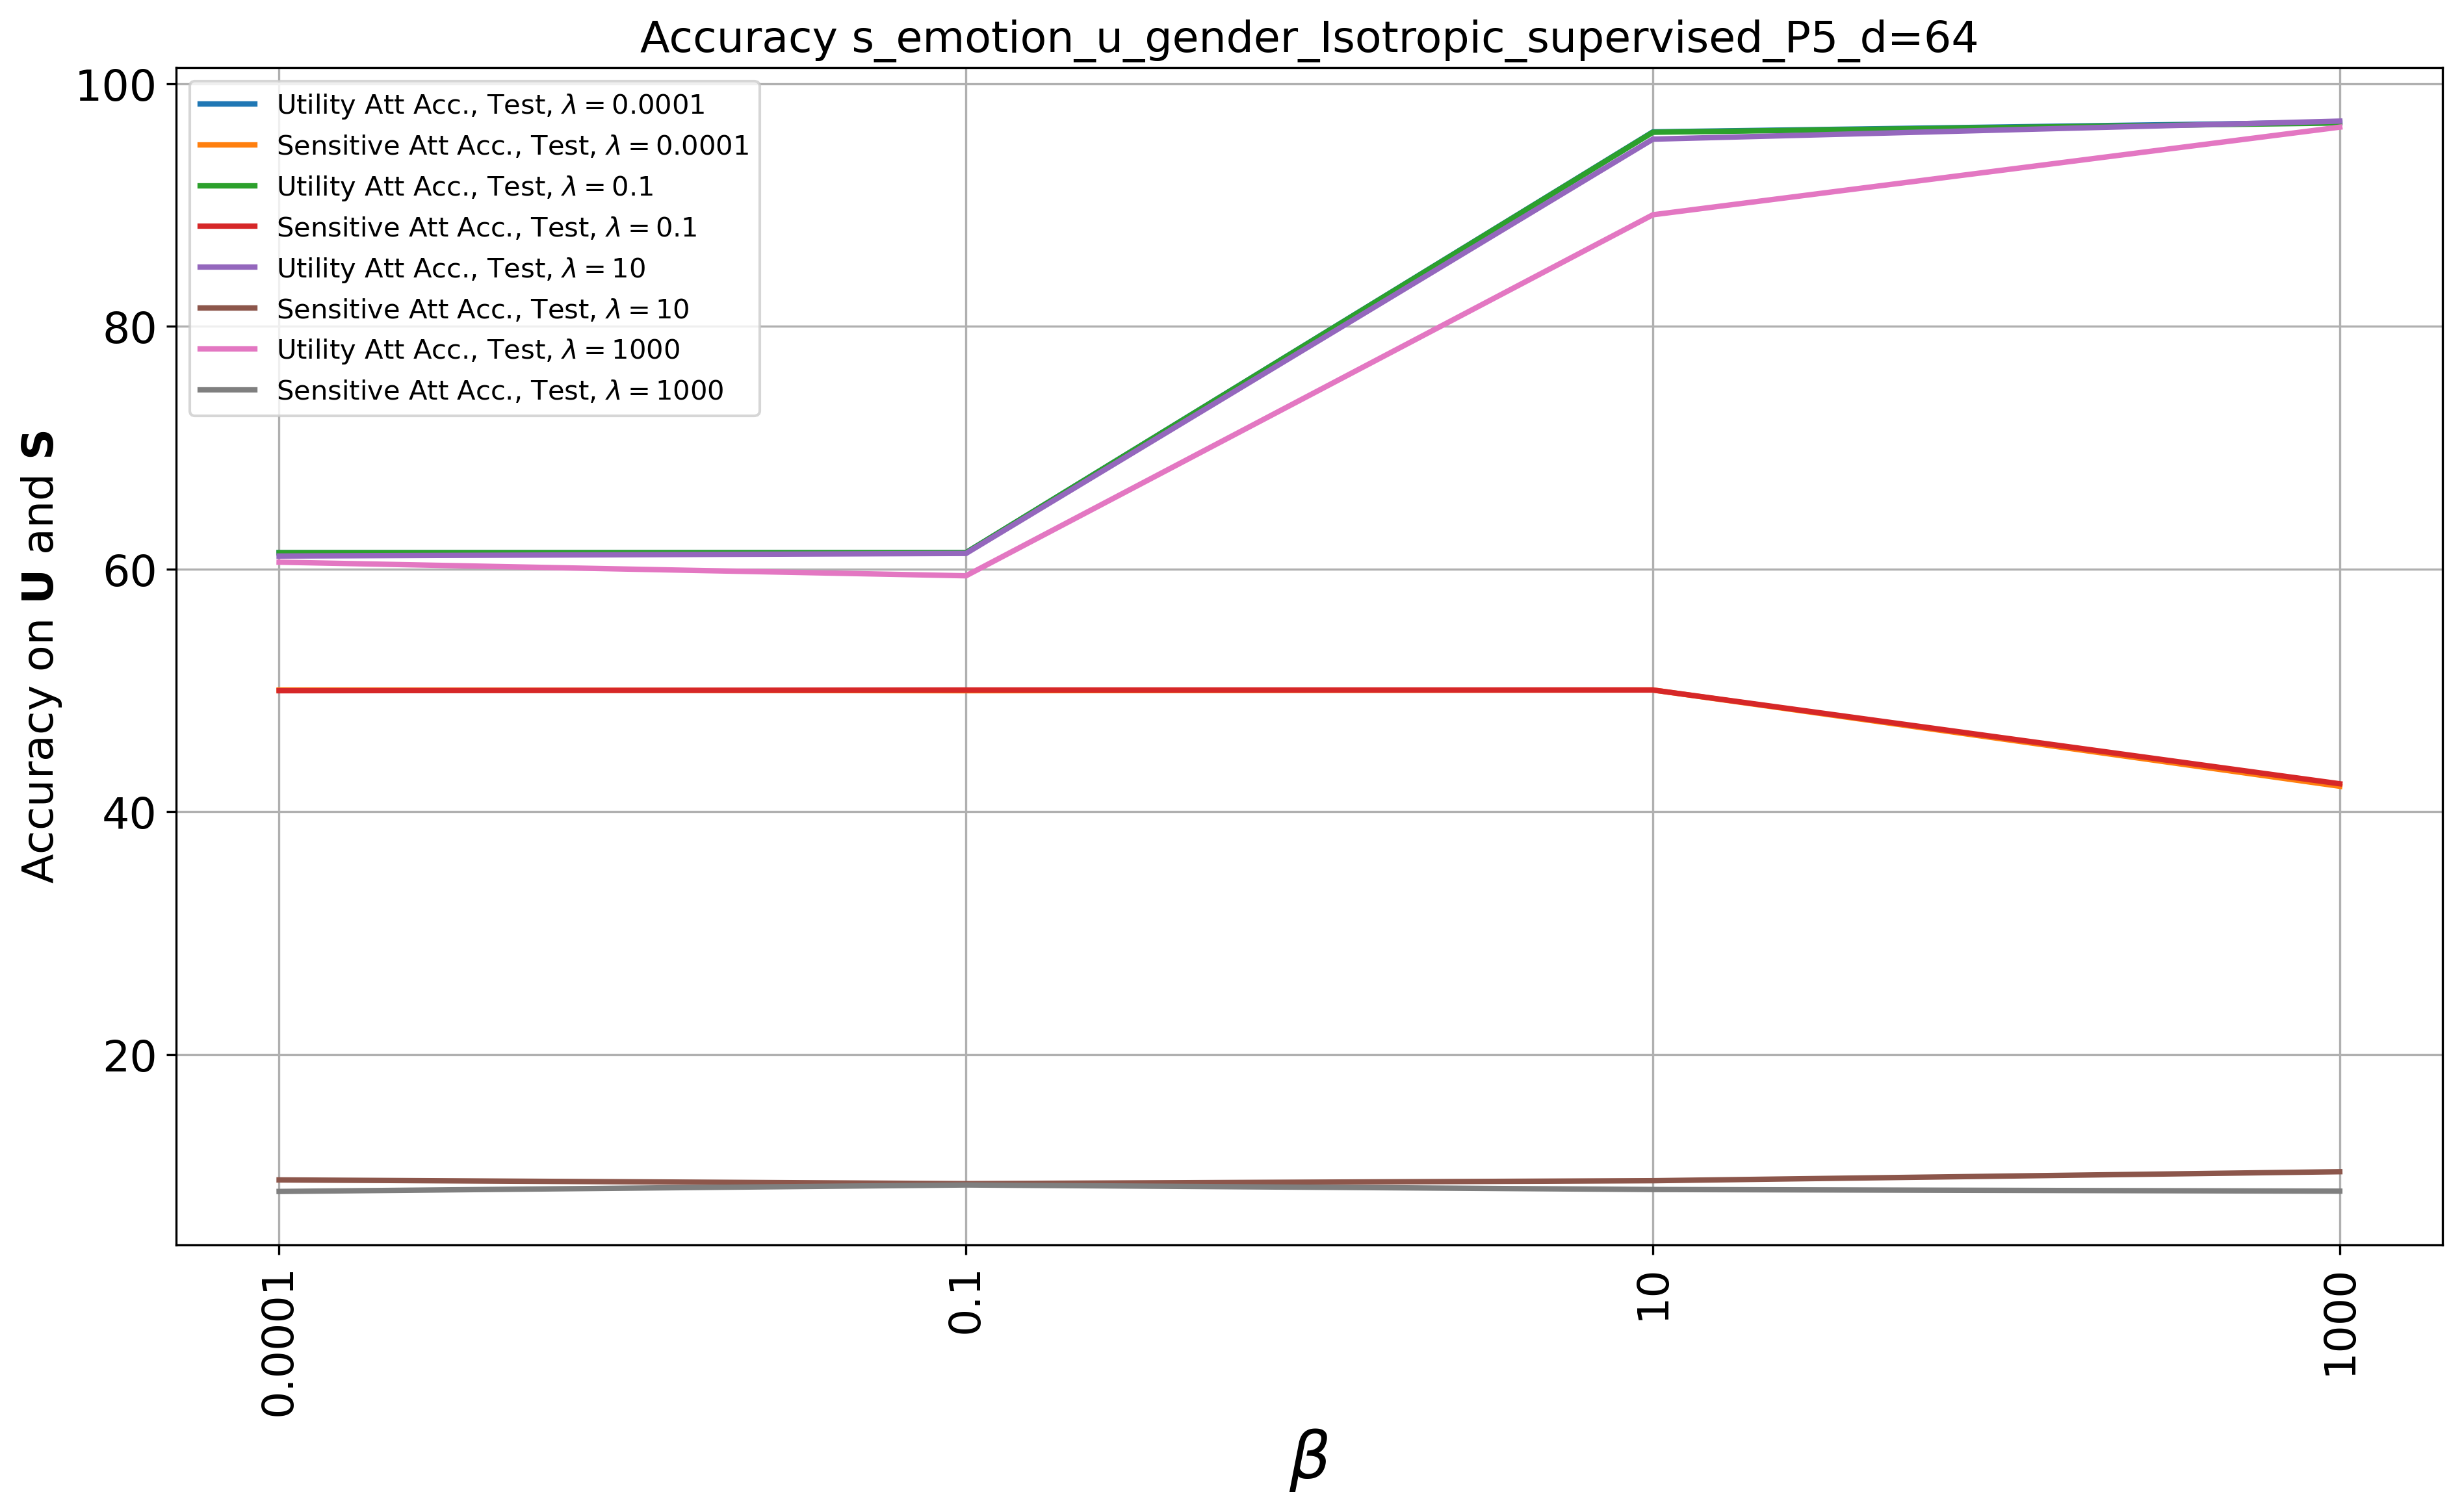

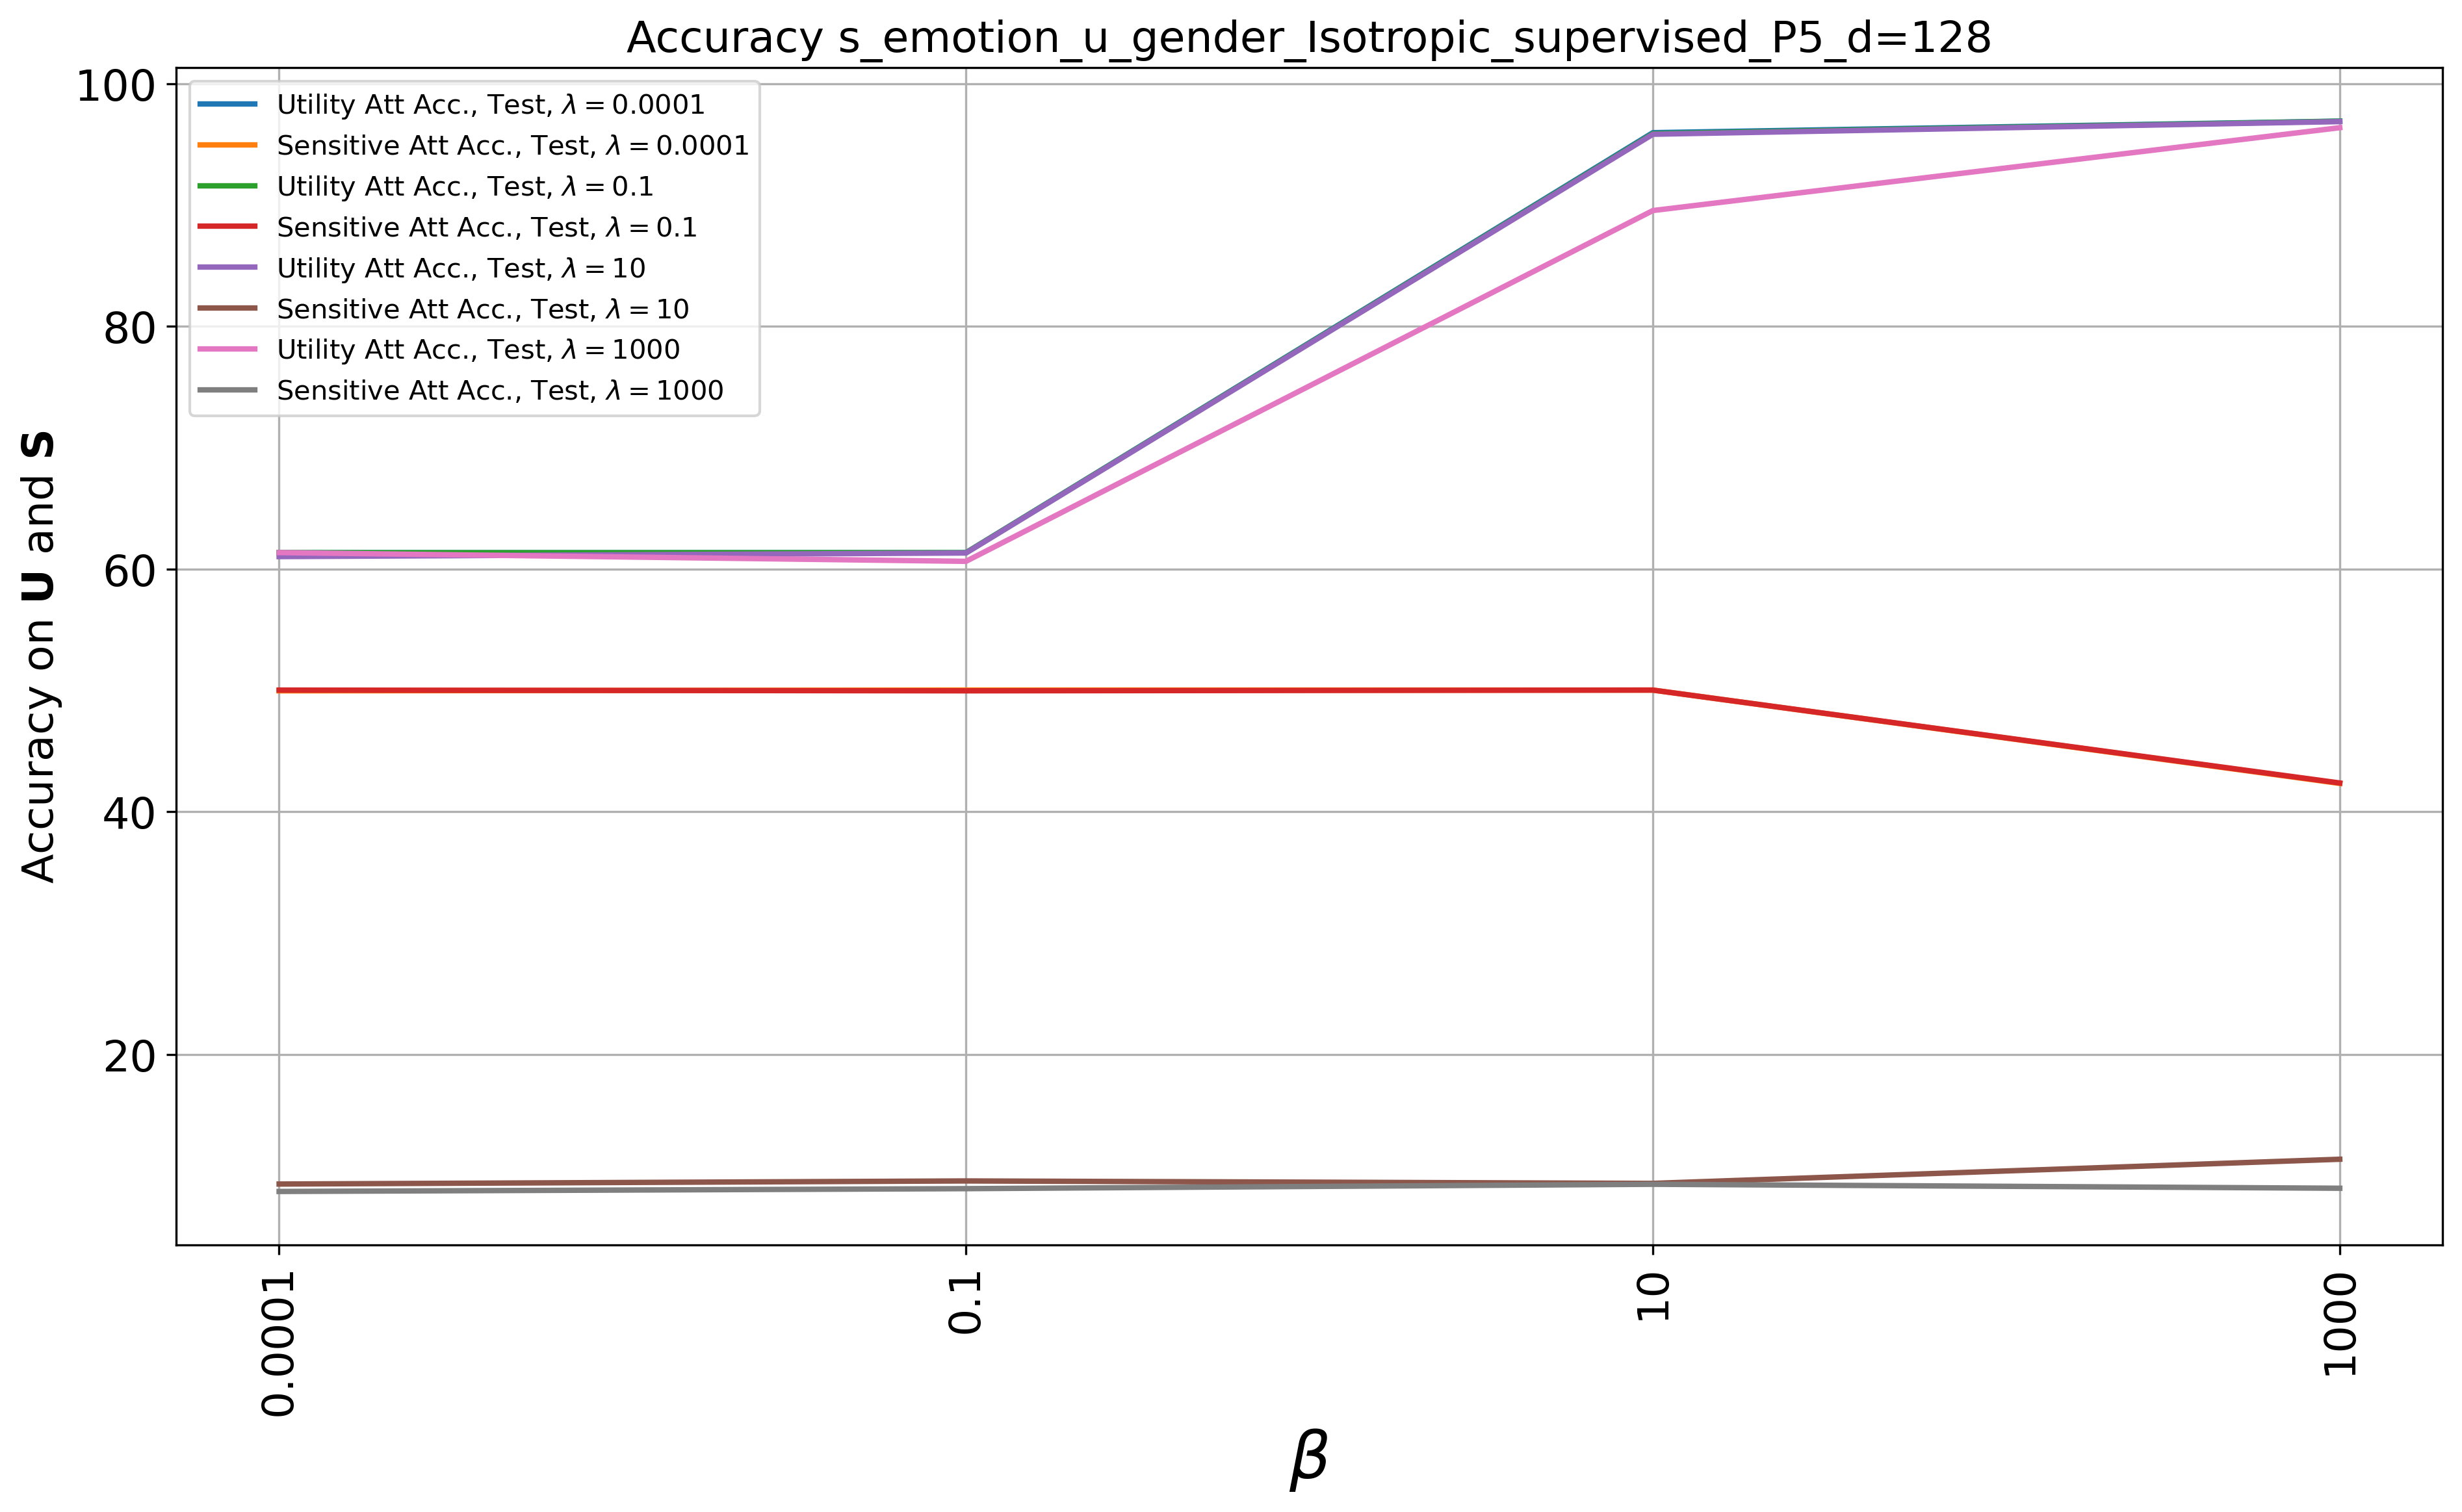

In [25]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 300
linestyles = ['-', '--', '-.', ':']
for i in range(util_acc_ts.shape[0]):
    plt.figure(figsize=(15,8))
    if supervised:
        plt.title(r'Accuracy ' + f'{exp_info}_d={DIM_Z[i]}', fontsize=16)
    else:
        plt.title(r'Accuracy and MSE ' + f'{exp_info}_d={DIM_Z[i]}', fontsize=16)
        
    for j in range(util_acc_ts.shape[1]):
        if supervised:
            plt.plot(util_acc_ts[i][j], label=r'Utility Att Acc., Test, $\lambda=$' + f"{lam_list[j]}", linestyle=linestyles[0], linewidth=2)
        else:
            plt.plot(util_acc_ts[i][j], label=r'Utility Att MSE., Test, $\lambda=$' + f"{lam_list[j]}", linestyle=linestyles[0], linewidth=2)
            
        plt.plot(sens_acc_ts[i][j], label=r'Sensitive Att Acc., Test, $\lambda=$' + f"{lam_list[j]}", linestyle=linestyles[0], linewidth=2)
        


    plt.legend(prop={'size': 10})
    plt.grid()
    plt.xticks(list(range(len(gamma_list))), gamma_list, fontsize=16, rotation=90)
    plt.xlabel(r'$\beta$', fontsize=24)
    if supervised:
        plt.ylabel(r'Accuracy on $\mathbf{U}$ and $\mathbf{S}$', fontsize=16)
        plt.savefig(f'./saved_figures/chart_celeba_acc_d_{DIM_Z[i]}_{exp_info}.eps', format='eps', bbox_inches='tight')
        plt.savefig(f'./saved_figures/chart_celeba_acc_d_{DIM_Z[i]}_{exp_info}.png', format='png', bbox_inches='tight')
    else:
        plt.ylabel(r'Accuracy and MSE on $\mathbf{U}$ and $\mathbf{S}$', fontsize=16)
        plt.savefig(f'./saved_figures/chart_celeba_acc_mse_d_{DIM_Z[i]}_{exp_info}.eps', format='eps', bbox_inches='tight')
        plt.savefig(f'./saved_figures/chart_celeba_acc_mse_d_{DIM_Z[i]}_{exp_info}.png', format='png', bbox_inches='tight')

## Plot accuracy (or MSE in unsupervised mode) (for each z and lambda we plot a chart for accuracy of the U and S)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

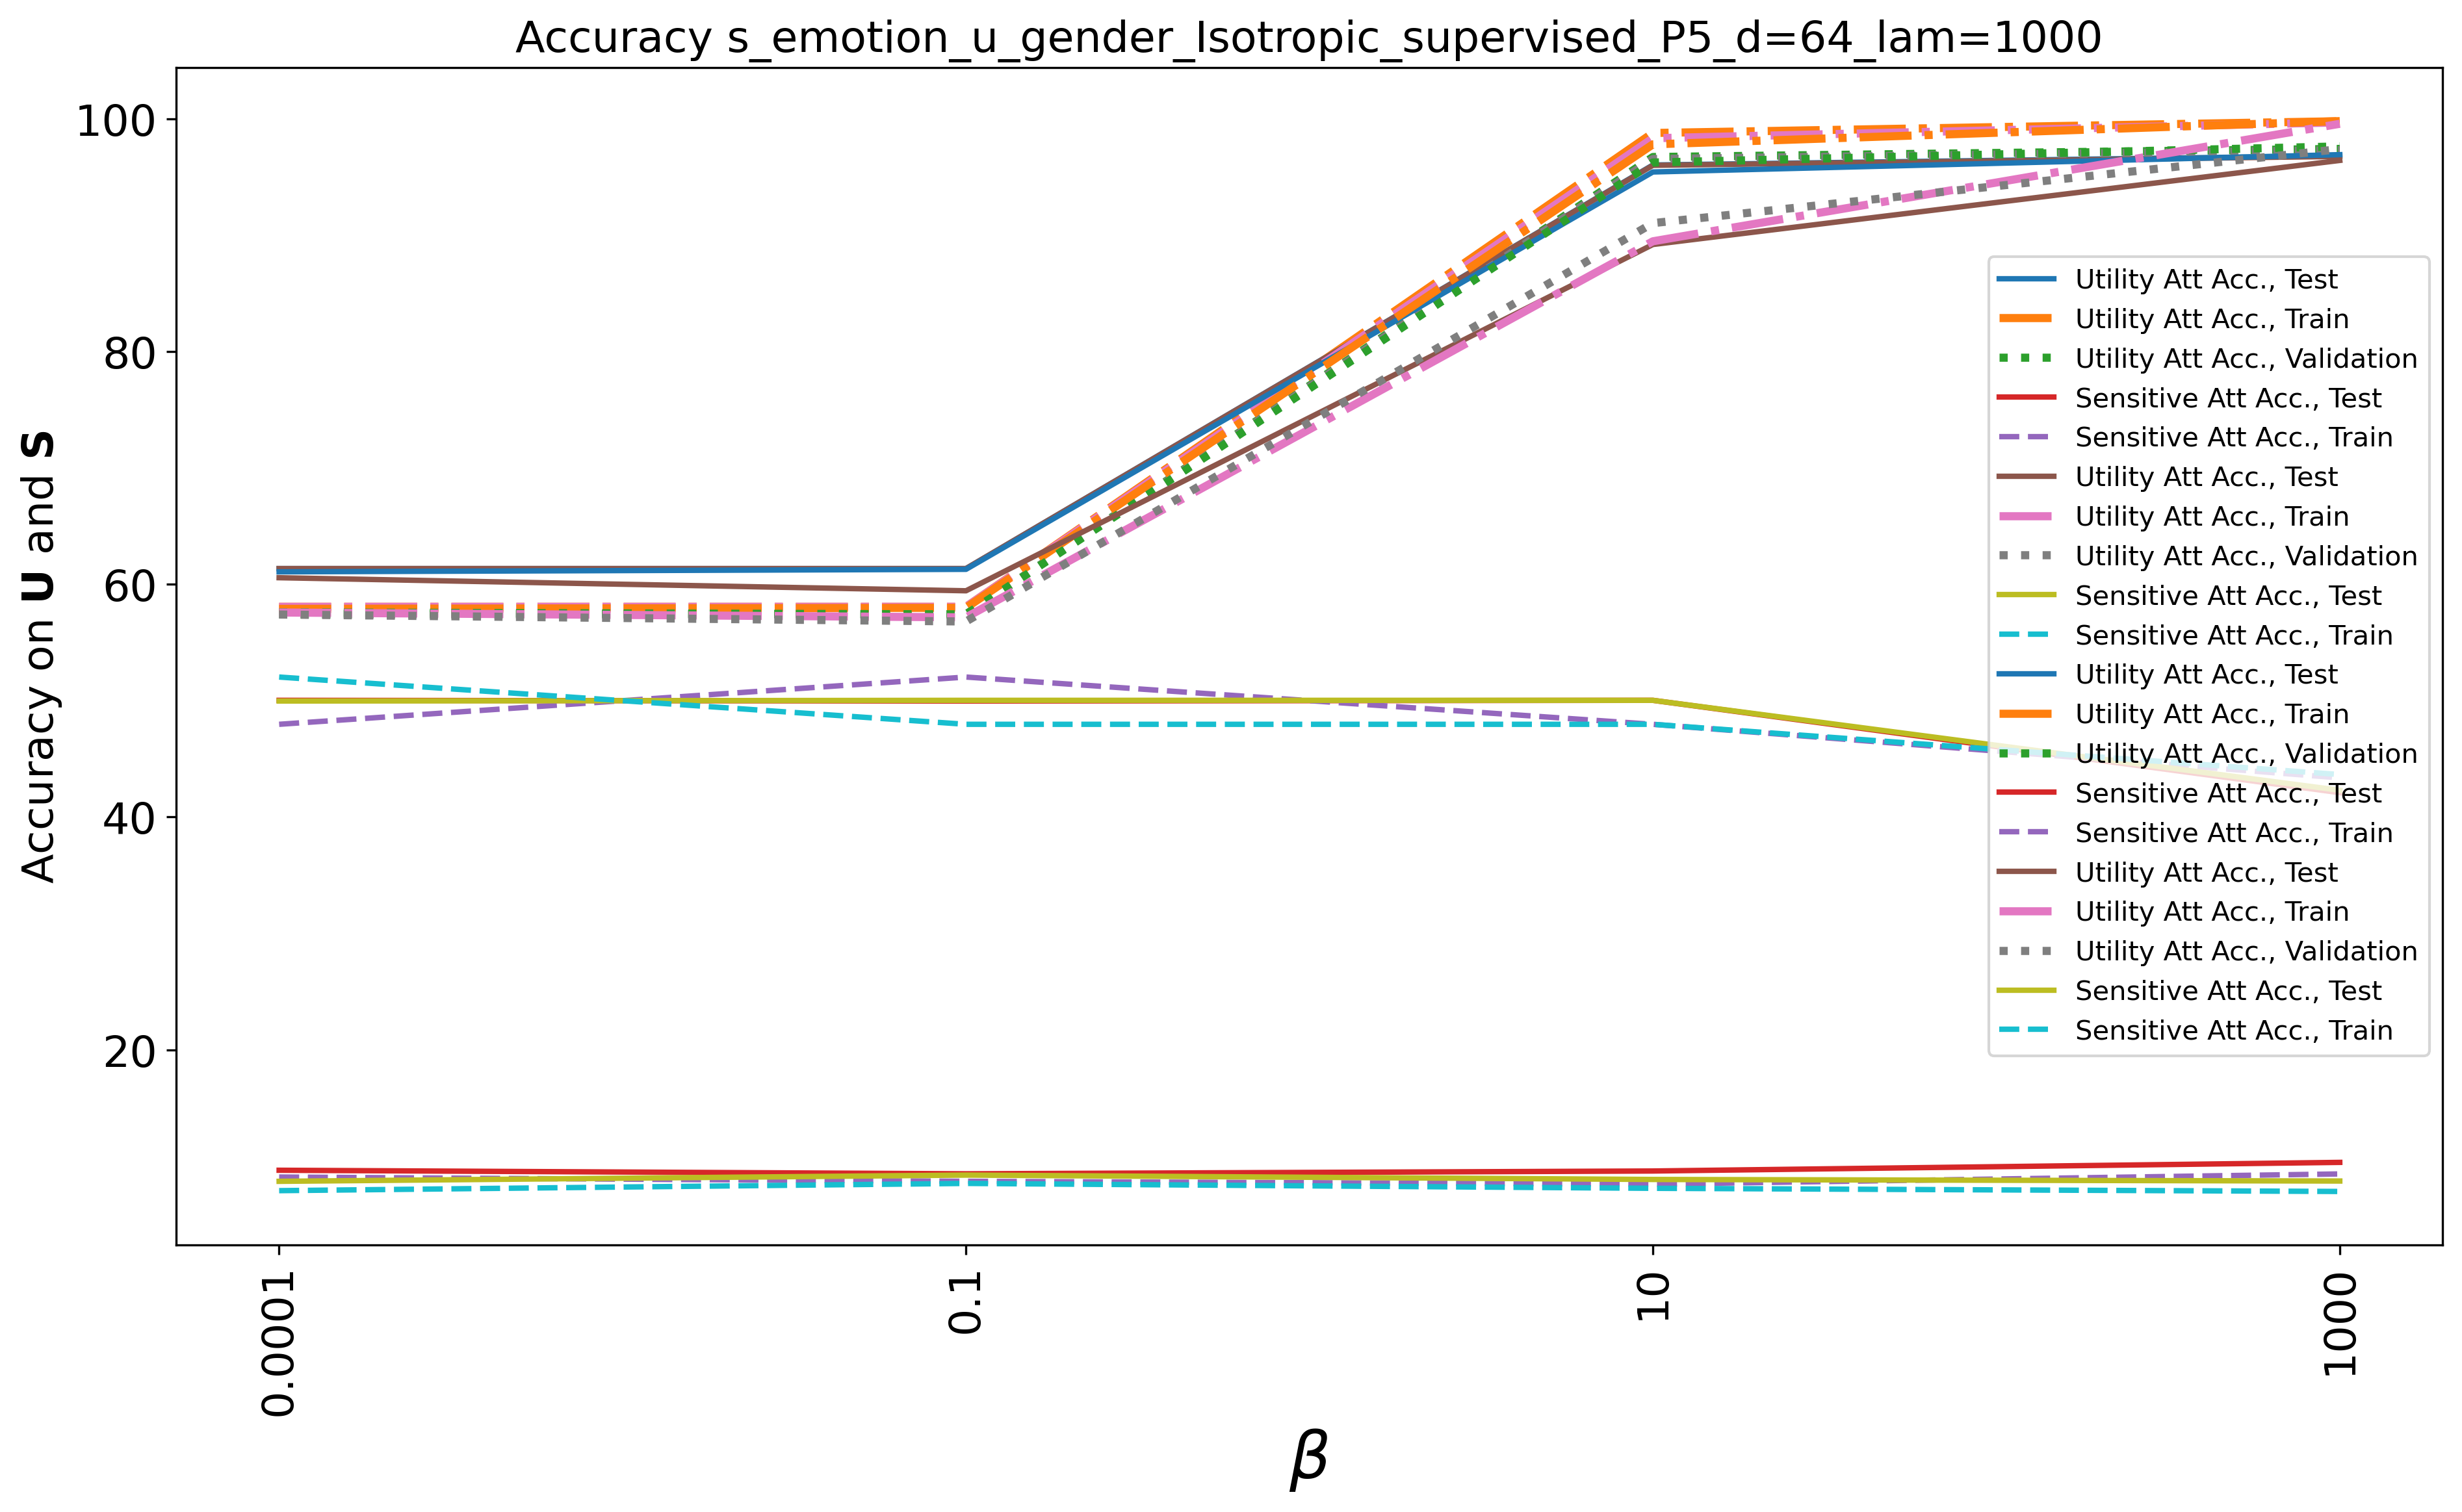

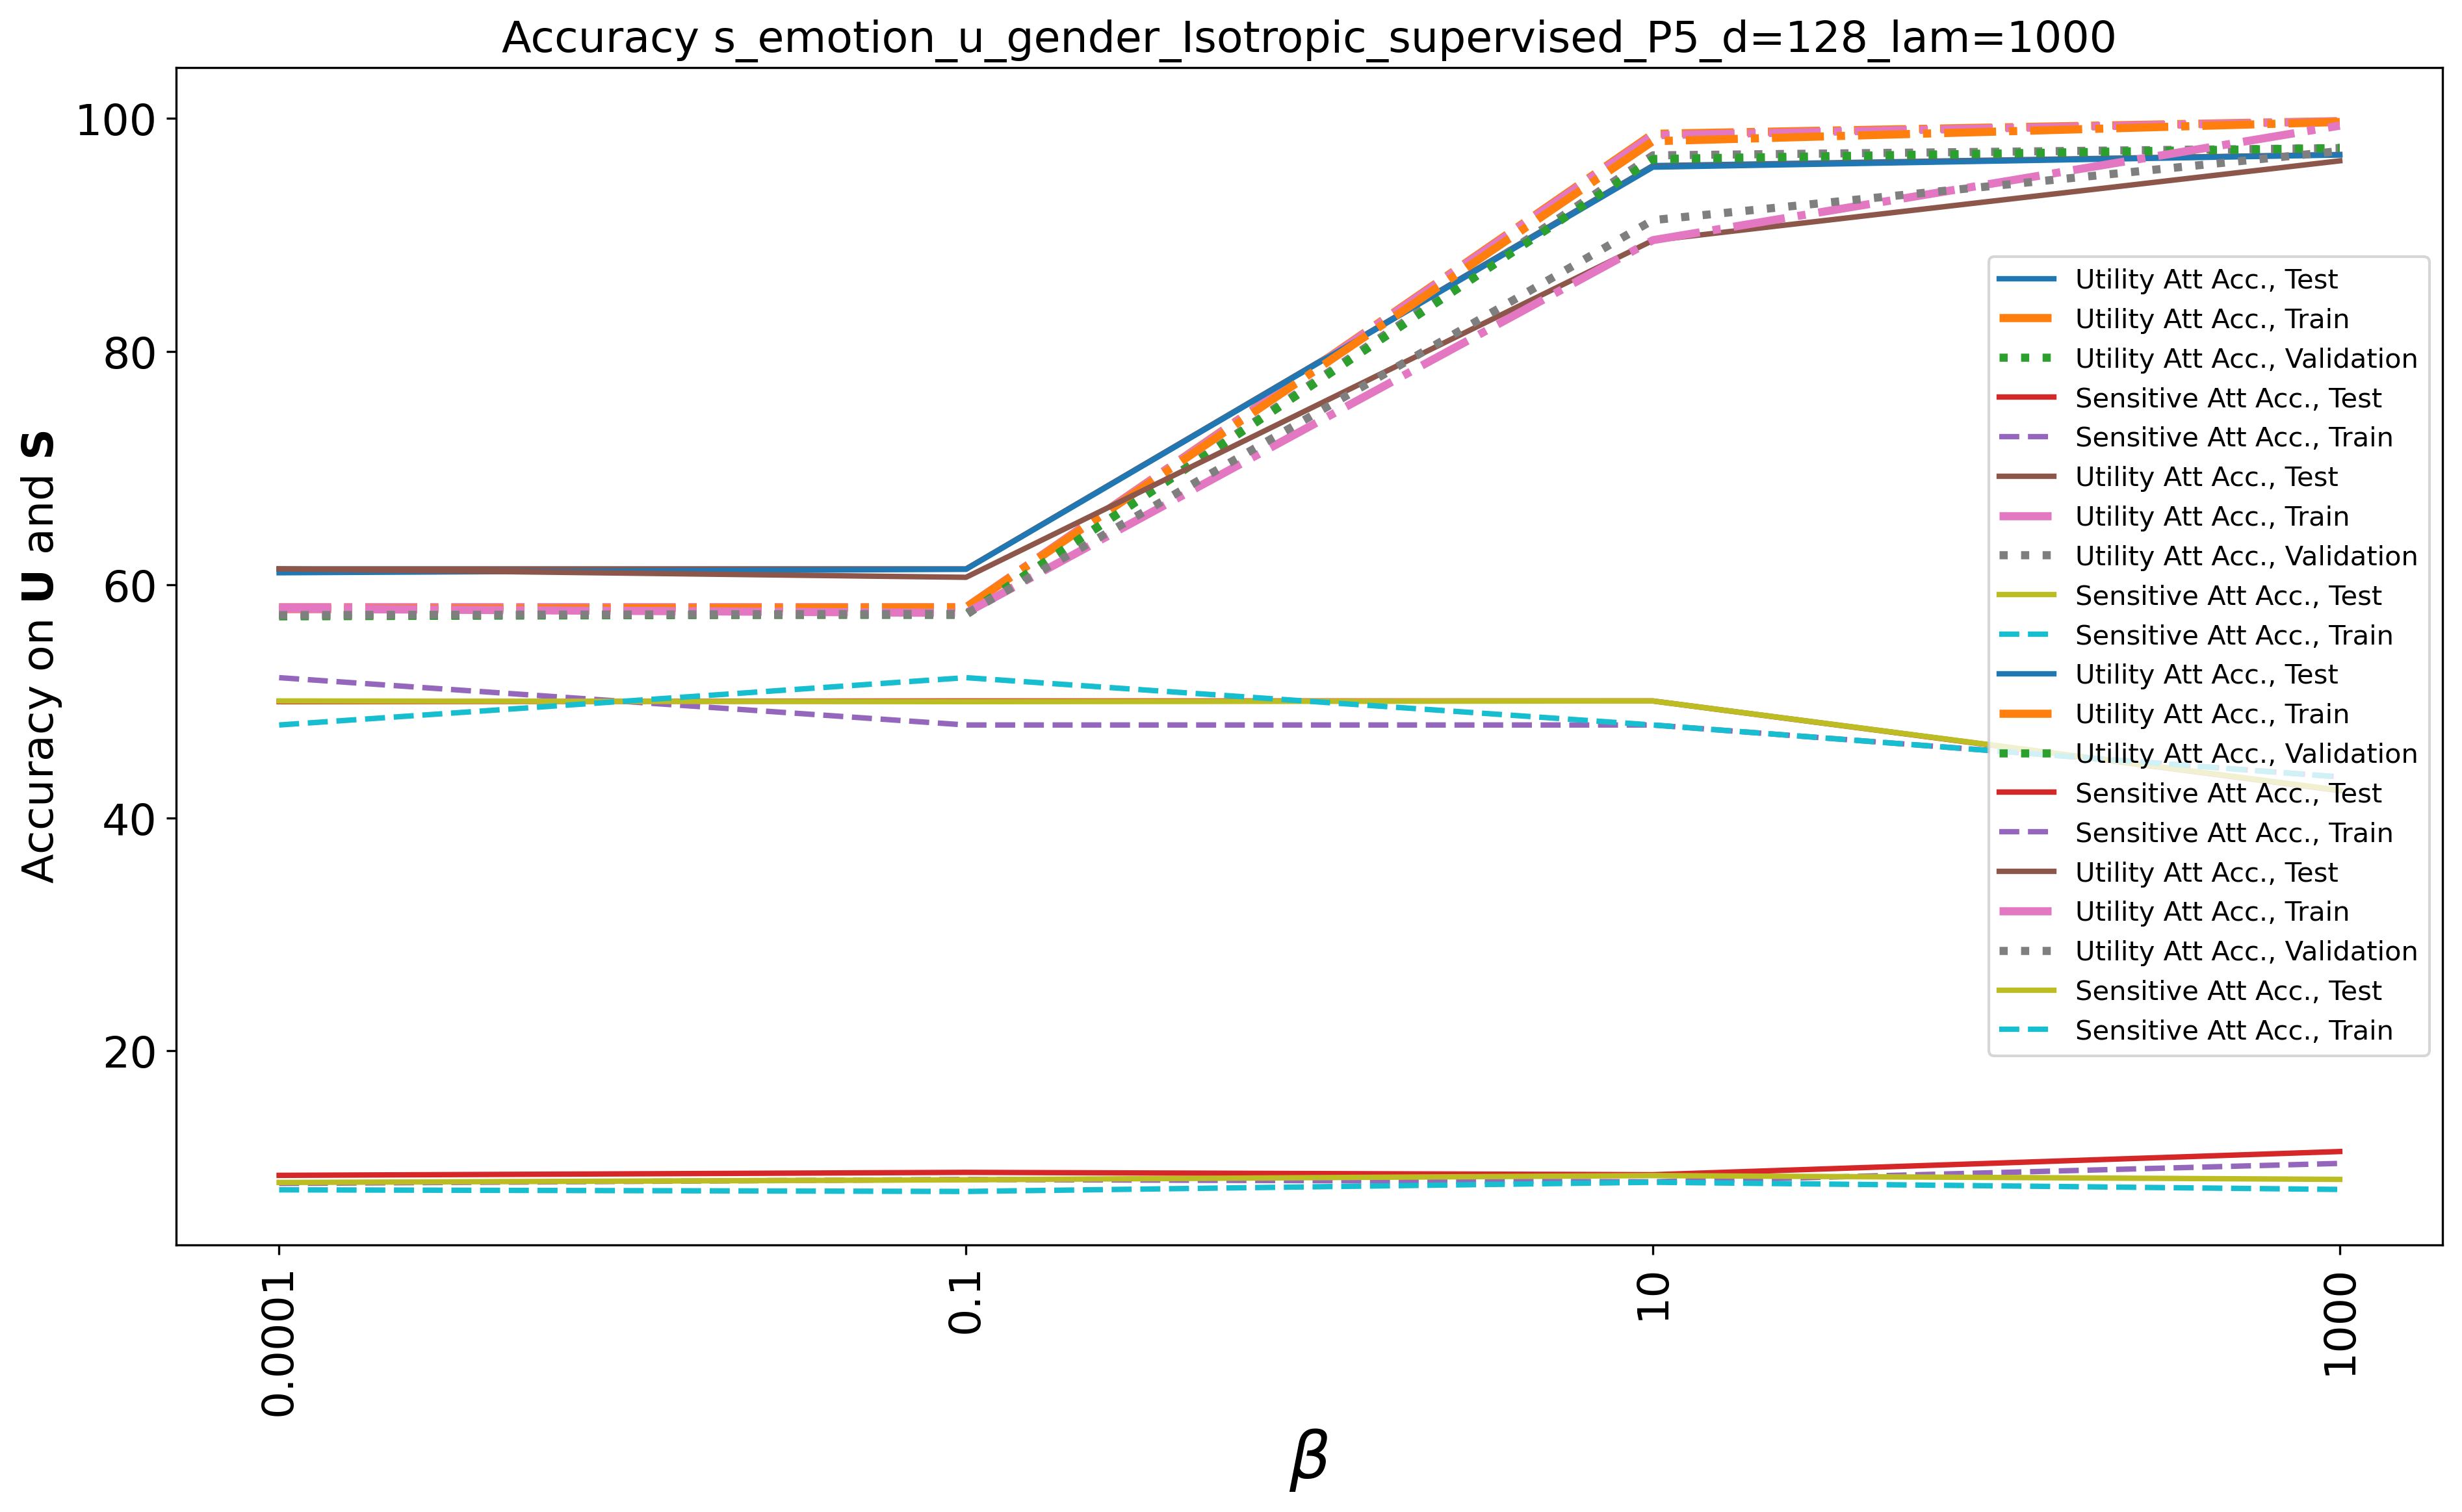

In [24]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 300
linestyles = ['-', '--', '-.', ':']
for i in range(util_acc_ts.shape[0]):
    plt.figure(figsize=(15,8))
    for j in range(util_acc_ts.shape[1]):
        if supervised:
            plt.title(r'Accuracy ' + f'{exp_info}_d={DIM_Z[i]}_lam={lam_list[j]}', fontsize=16)
            plt.plot(util_acc_ts[i][j], label=r'Utility Att Acc., Test', linestyle=linestyles[0], linewidth=2)
            plt.plot(util_acc_tr[i][j], label=r'Utility Att Acc., Train', linestyle=linestyles[2], linewidth=3)
            plt.plot(util_acc_va[i][j], label=r'Utility Att Acc., Validation', linestyle=linestyles[3], linewidth=3)
            
            plt.plot(sens_acc_ts[i][j], label=r'Sensitive Att Acc., Test', linestyle=linestyles[0], linewidth=2)
            plt.plot(sens_acc_tr[i][j], label=r'Sensitive Att Acc., Train', linestyle=linestyles[1], linewidth=2)
        else:
            plt.title(r'Accuracy and MSE ' + f'{exp_info}_d={DIM_Z[i]}_lam={lam_list[j]}', fontsize=16)
            plt.plot(util_acc_ts[i][j], label=r'Utility Att MSE., Test', linestyle=linestyles[0], linewidth=2)
            plt.plot(util_acc_tr[i][j], label=r'Utility Att MSE., Train', linestyle=linestyles[1], linewidth=3)
            plt.plot(util_acc_va[i][j], label=r'Utility Att MSE., Validation', linestyle=linestyles[2], linewidth=3)

        plt.legend(prop={'size': 10})
        plt.grid()
        plt.xticks(list(range(len(gamma_list))), gamma_list, fontsize=16, rotation=90)
        plt.xlabel(r'$\beta$', fontsize=24)
        if supervised:
            plt.ylabel(r'Accuracy on $\mathbf{U}$ and $\mathbf{S}$', fontsize=16)
            plt.savefig(f'./saved_figures/chart_celeba_acc_d_{DIM_Z[i]}_lambda_{lam_list[j]}_{exp_info}.eps', format='eps', bbox_inches='tight')
            plt.savefig(f'./saved_figures/chart_celeba_acc_d_{DIM_Z[i]}_lambda_{lam_list[j]}_{exp_info}.png', format='png', bbox_inches='tight')
        else:
            plt.ylabel(r'Accuracy and MSE on $\mathbf{U}$ and $\mathbf{S}$', fontsize=16)
            plt.savefig(f'./saved_figures/chart_celeba_acc_mse_d_{DIM_Z[i]}_lambda_{lam_list[j]}_{exp_info}.eps', format='eps', bbox_inches='tight')
            plt.savefig(f'./saved_figures/chart_celeba_acc_mse_d_{DIM_Z[i]}_lambda_{lam_list[j]}_{exp_info}.png', format='png', bbox_inches='tight')

## Plot mutual information between Z and S

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


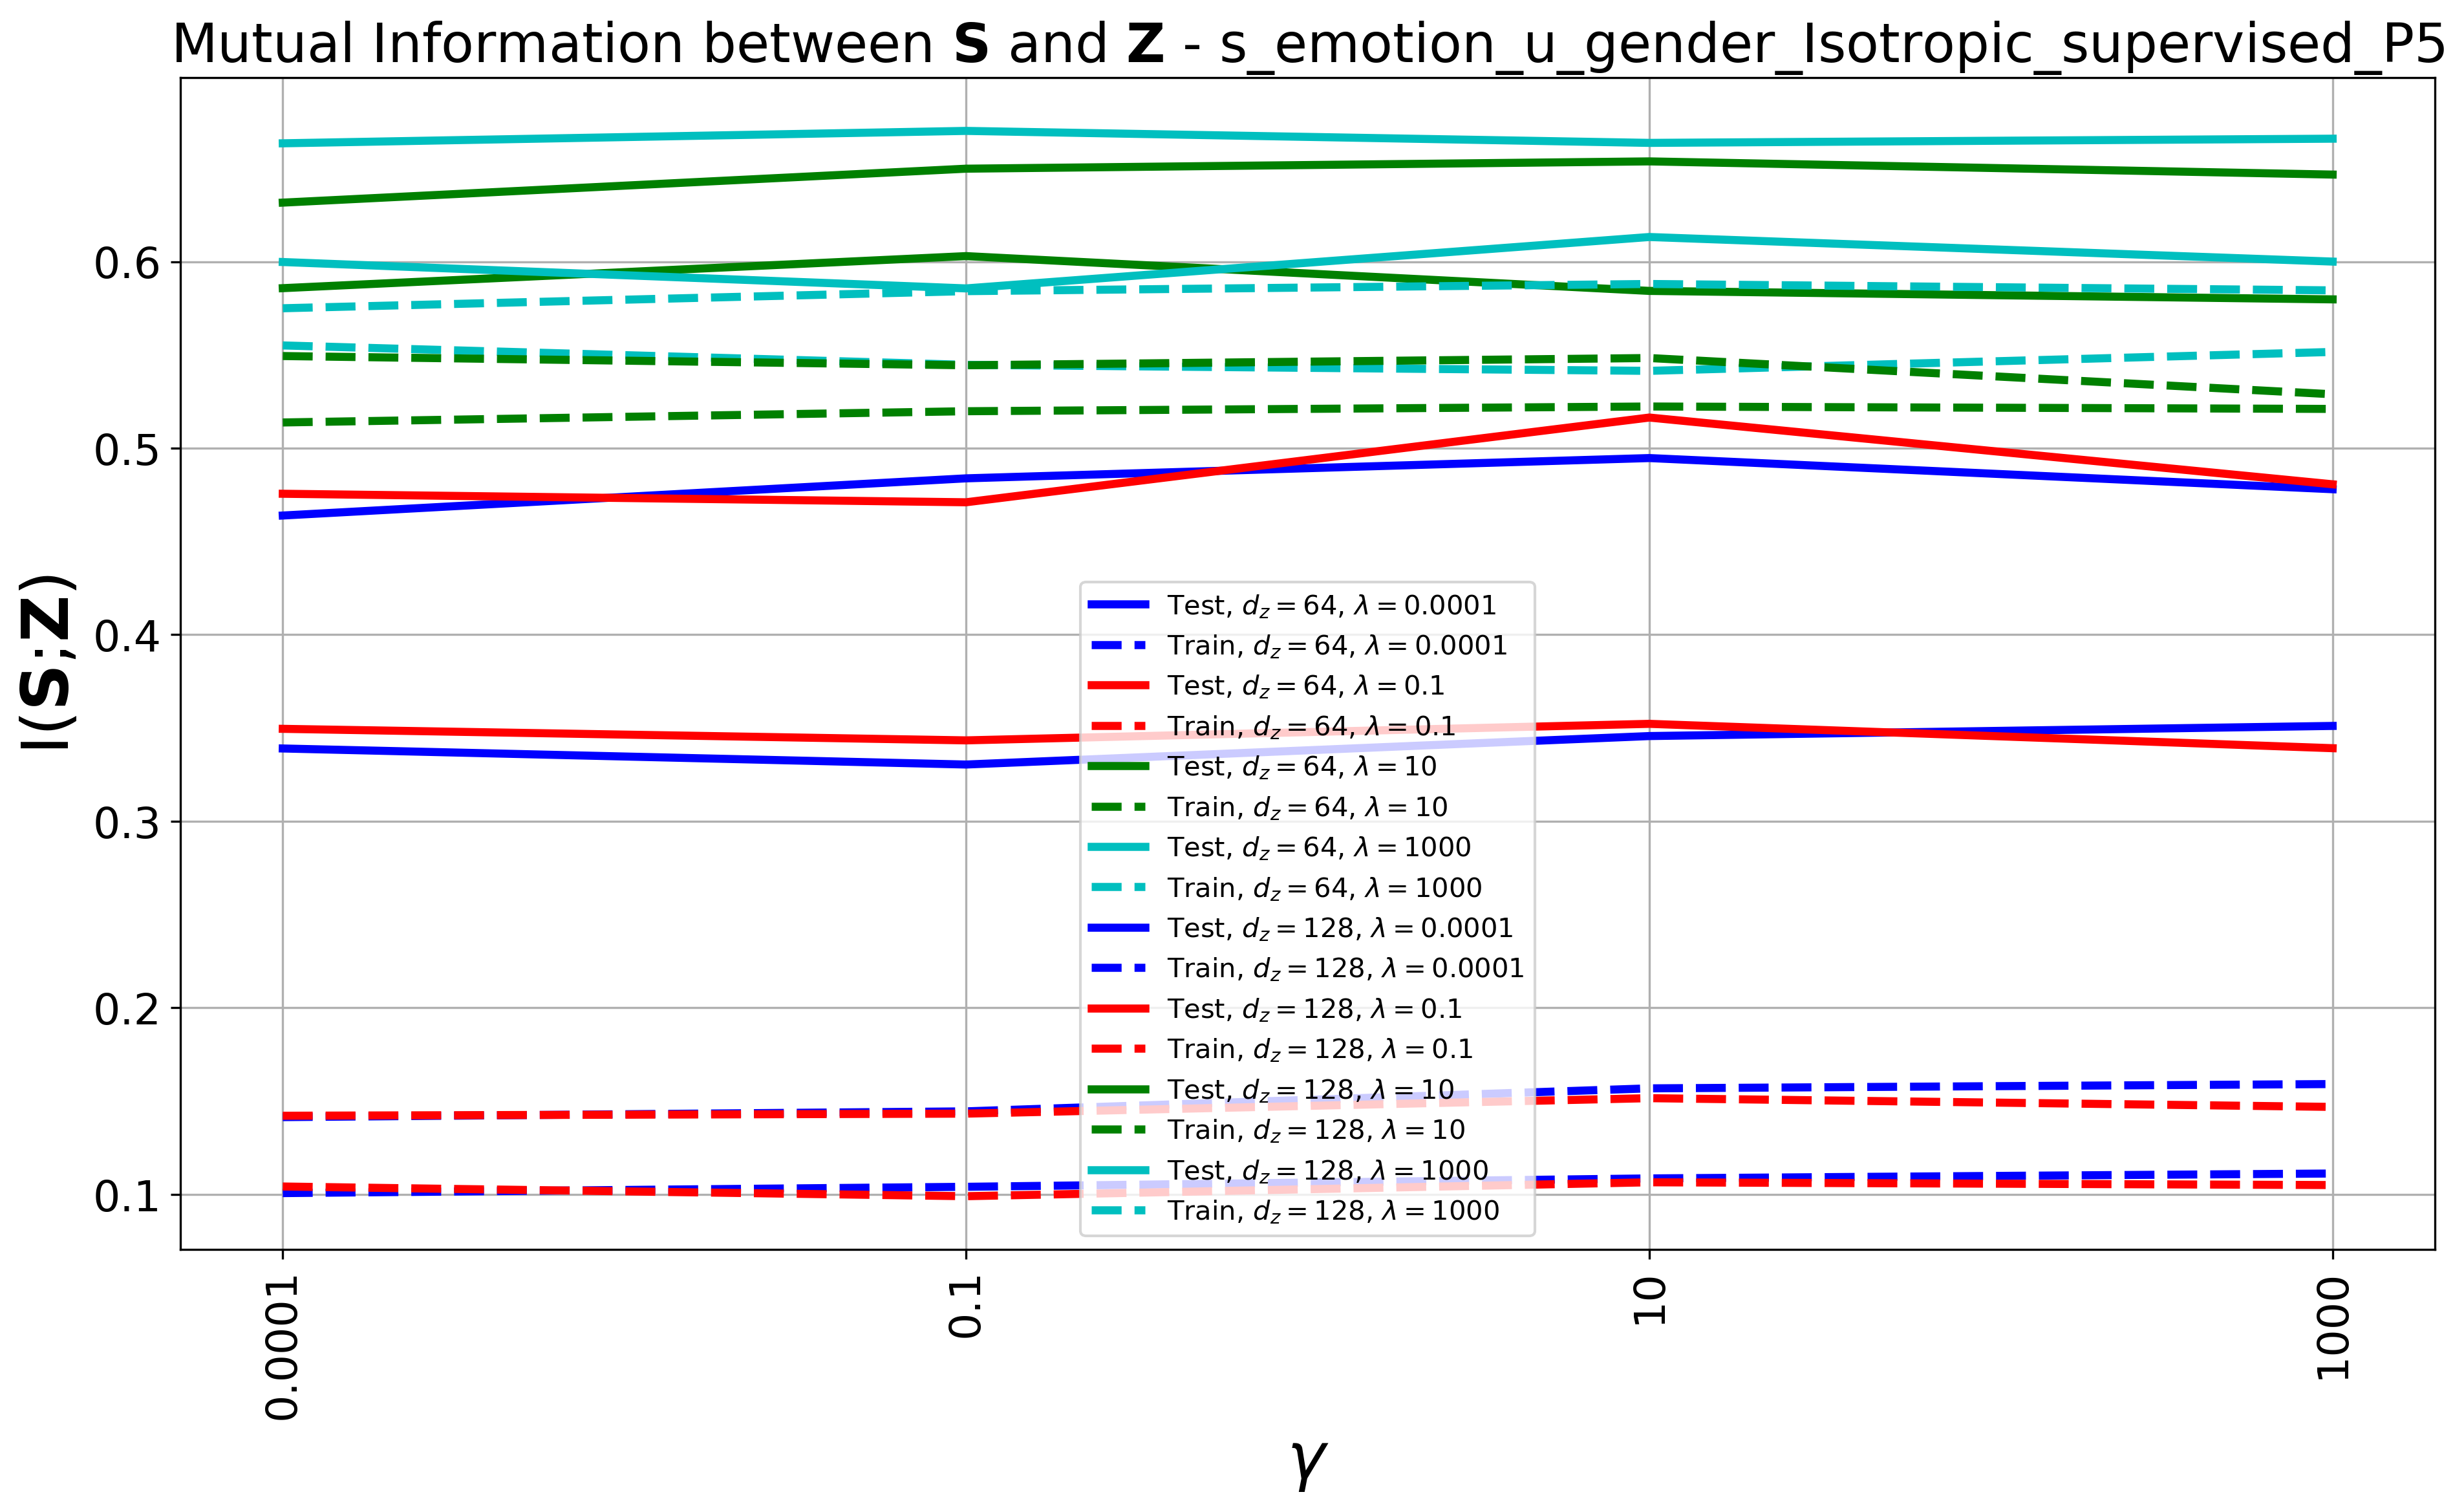

In [23]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(15,8))
plt.title(r'Mutual Information between $\mathbf{S}$ and $\mathbf{Z}$' + f' - {exp_info}', fontsize=20)
linestyles = ['-', '--', '-.', ':']
colors = ['b', 'r', 'g', 'c']
for i in range(mi_s_ts.shape[0]):
    for j in range(mi_s_ts.shape[1]):
        plt.plot(mi_s_ts[i][j], label=r'Test, $d_z=$' + f'{DIM_Z[i]}' + r', $\lambda=$' + f"{lam_list[j]}", linestyle=linestyles[0], c=colors[j%len(colors)] ,linewidth=3)
        plt.plot(mi_s_tr[i][j], label=r'Train, $d_z=$' + f'{DIM_Z[i]}' + r', $\lambda=$' + f"{lam_list[j]}", linestyle=linestyles[1], c=colors[j%len(colors)] ,linewidth=3)
        
# plt.xscale('linear')
plt.xlabel(r'$\gamma$', fontsize=24)
plt.xticks(list(range(len(gamma_list))), gamma_list, rotation=90)

plt.ylabel(r'I($\mathbf{S}$;$\mathbf{Z}$)', fontsize=24)
plt.legend(prop={'size': 10})
plt.grid()
plt.savefig(f'./saved_figures/chart_celeba_mi_zs_{exp_info}.eps', format='eps', bbox_inches='tight')
plt.savefig(f'./saved_figures/chart_celeba_mi_zs_{exp_info}.png', format='png', bbox_inches='tight')
plt.show()

## Plot mutual information between Z and U

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


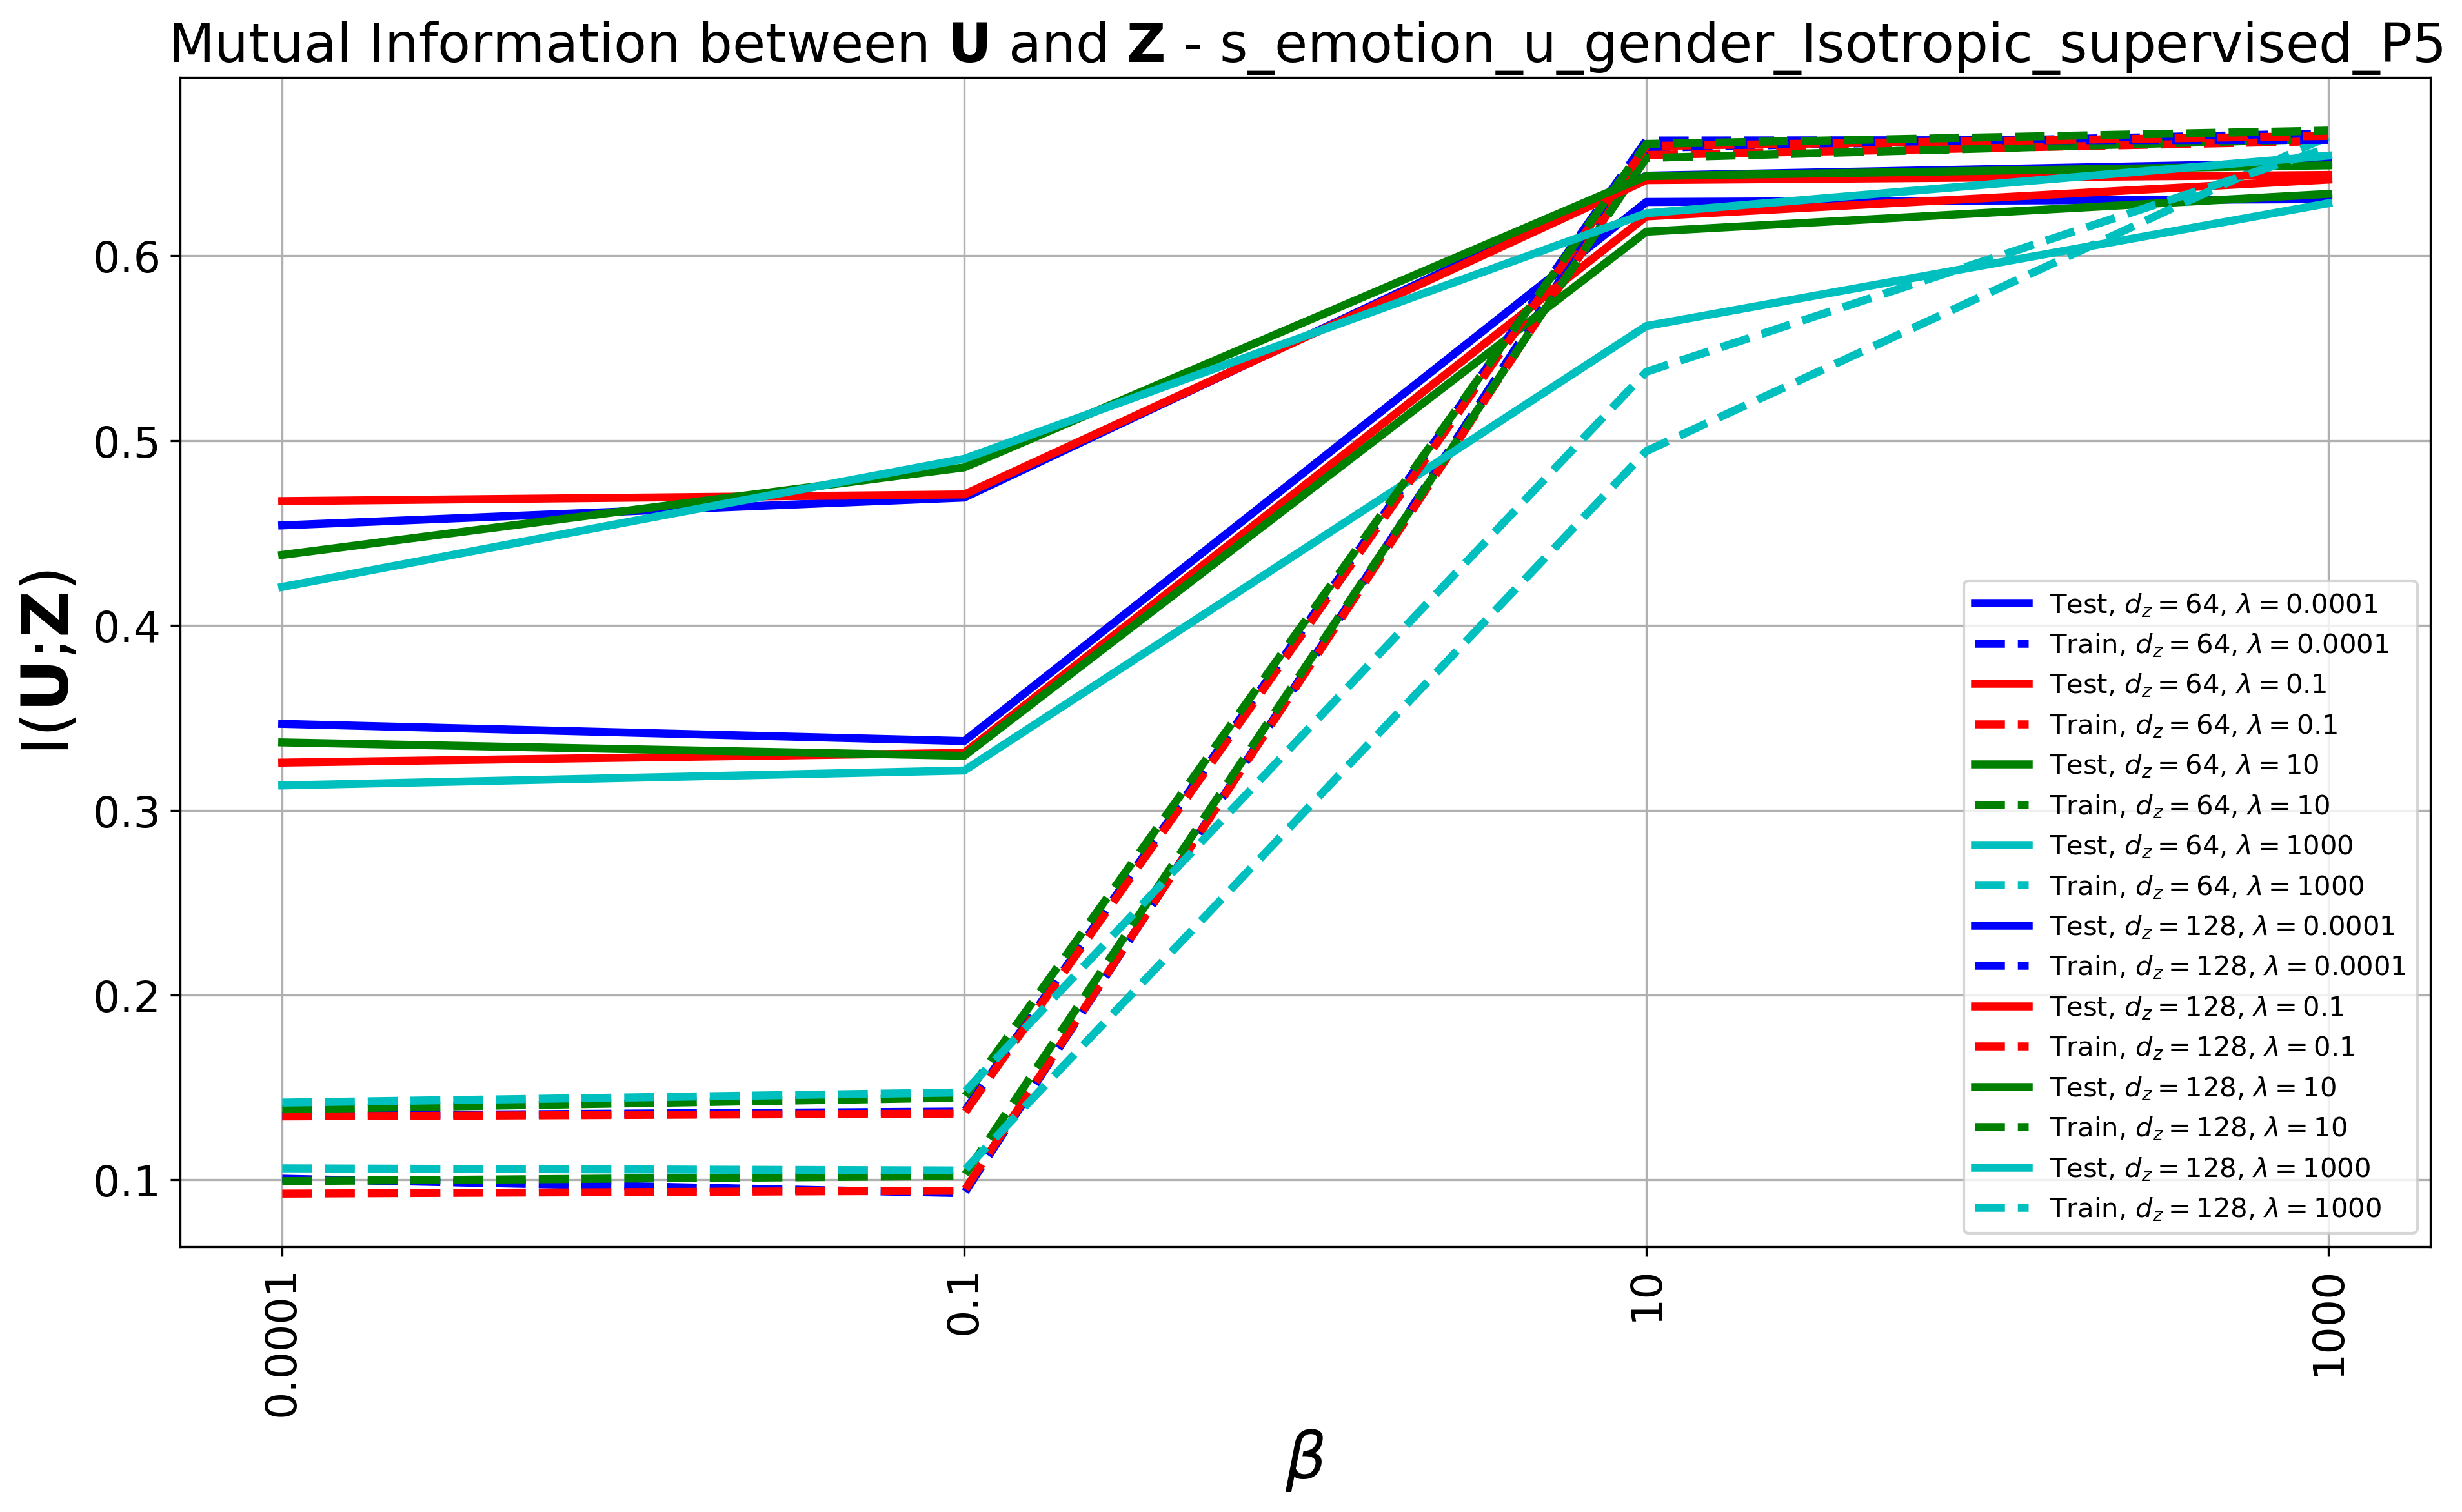

In [26]:
if supervised:
    plt.rcParams.update({'font.size': 16})
    plt.rcParams['figure.dpi'] = 300
    plt.figure(figsize=(15,8))
    plt.title(r'Mutual Information between $\mathbf{U}$ and $\mathbf{Z}$' + f' - {exp_info}', fontsize=20)
    linestyles = ['-', '--', '-.', ':']
    colors = ['b', 'r', 'g', 'c']
    for i in range(mi_u_ts.shape[0]):
        for j in range(mi_u_ts.shape[1]):
            plt.plot(mi_u_ts[i][j], label=r'Test, $d_z=$' + f'{DIM_Z[i]}' + r', $\lambda=$' + f"{lam_list[j]}", linestyle=linestyles[0], c=colors[j%len(colors)] ,linewidth=3)
            plt.plot(mi_u_tr[i][j], label=r'Train, $d_z=$' + f'{DIM_Z[i]}' + r', $\lambda=$' + f"{lam_list[j]}", linestyle=linestyles[1], c=colors[j%len(colors)] ,linewidth=3)

    # plt.xscale('linear')
    plt.xlabel(r'$\beta$', fontsize=24)
    plt.xticks(list(range(len(gamma_list))), gamma_list,rotation=90)

    plt.ylabel(r'I($\mathbf{U}$;$\mathbf{Z}$)', fontsize=24)
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.savefig(f'./saved_figures/chart_celeba_mi_zu_{exp_info}.eps', format='eps', bbox_inches='tight')
    plt.savefig(f'./saved_figures/chart_celeba_mi_zu_{exp_info}.png', format='png', bbox_inches='tight')
    plt.show()

# Save results values to file

In [ ]:
import scipy.io as sio
sio.savemat(f'./saved_data/acc_celeba_{exp_info}.mat', {'util_acc_ts':util_acc_ts, 'util_acc_tr':util_acc_tr, 'util_acc_va':util_acc_va, 'sens_acc_ts':sens_acc_ts, 'sens_acc_tr':sens_acc_tr})
sio.savemat(f'./saved_data/mi_celeba_{exp_info}.mat', {'mi_s_ts':mi_s_ts, 'mi_s_tr':mi_s_tr, 'mi_u_ts':mi_u_ts, 'mi_u_tr':mi_u_tr})

# Load results from file

In [20]:
import scipy.io as sio
mat_contents  = sio.loadmat(f'./saved_data/acc_celeba_{exp_info}.mat')
util_acc_ts = mat_contents['util_acc_ts']
util_acc_tr = mat_contents['util_acc_tr']
util_acc_va = mat_contents['util_acc_va']
sens_acc_ts = mat_contents['sens_acc_ts']
sens_acc_tr = mat_contents['sens_acc_tr']


mat_contents  = sio.loadmat(f'./saved_data/mi_celeba_{exp_info}.mat')
mi_s_tr = mat_contents['mi_s_tr']
mi_s_ts = mat_contents['mi_s_ts']
mi_u_ts = mat_contents['mi_u_ts']
mi_u_tr = mat_contents['mi_u_tr']